In [37]:
# Librerias a usar
from funciones import *

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


#Definimos un máximo de hilos a usar
""" os.environ["OMP_NUM_THREADS"] = "3" 
cv2.setNumThreads(3)  """

' os.environ["OMP_NUM_THREADS"] = "3" \ncv2.setNumThreads(3)  '

# Este notebook presenta el uso de grid search para mejorar los hiperparámetros del modelo. Sobre las imagenes, se escogió el preprocesamiento que mejores resultados habia tenido previamente.

In [38]:
ruta_imagenes = "../img"
clases = ['normal', 'grieta', 'hueco']

df = load_images(img_directorio_path=ruta_imagenes, classes=clases)

In [39]:
from sklearn.preprocessing import LabelEncoder

# Codificar etiquetas
le = LabelEncoder()

df['clase'] = le.fit_transform(df['clase']) 

In [40]:
import random

# Generar semilla aleatoria
seed = random.randint(0, 10000)
print(f"Semilla usada para el shuffle: {seed}")

# Aplicar shuffle para asegurarnos que las imagenes se selecciones aleatoriamente
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

Semilla usada para el shuffle: 5228


### Preprocesamiento de las imagenes

In [ ]:
def gaussian_blur(imagen):
    imagen = cv2.convertScaleAbs(imagen, alpha=1.2, beta=6)
    return cv2.GaussianBlur(imagen, (3, 3), 2)

def sobel(imagen):
    sobelx = cv2.Sobel(imagen, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(imagen, cv2.CV_64F, 0, 1)
    return cv2.magnitude(sobelx, sobely).astype(np.uint8)


imagen_brillo = [gaussian_blur(imagen) for imagen in df['imagen gris']]

imagen_sobel = [sobel(imagen) for imagen in imagen_brillo]

sift = cv2.SIFT_create()

descriptores_imagen = []

descriptores_unidos = []

for imagen in imagen_sobel:
    keypoints, descriptors = sift.detectAndCompute(imagen, None)

    if descriptors is not None:
            keypoints_ordenados = sorted(keypoints, key=lambda kp: kp.response, reverse=True)[:1000]
            descriptors_ordenados = np.array([descriptors[keypoints.index(kp)] for kp in keypoints_ordenados])
            descriptores_imagen.append(descriptors_ordenados)
            descriptores_unidos.append(descriptors_ordenados)
    else:
          descriptores_imagen.append(np.zeros((1, 128), dtype=np.float32))
          descriptores_unidos.append(np.zeros((1, 128), dtype=np.float32))

descriptores_unidos = np.vstack(descriptores_unidos)

### Bag of Visual Words

Calculando KMeans y Silhouette (sample): 100%|██████████| 8/8 [01:17<00:00,  9.73s/it]


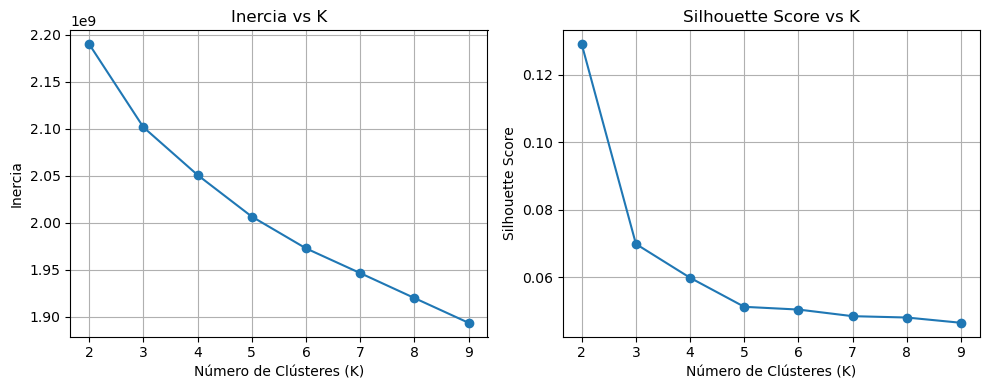

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import matplotlib.pyplot as plt


inertia = []
silhouette_scores = []
k_values = range(2, 10)

from sklearn.utils import shuffle

muestra = shuffle(descriptores_unidos, random_state=70)[:20000]  # reduce datos de entrenamiento

for k in tqdm(k_values, desc="Calculando KMeans y Silhouette (sample)"):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(muestra)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(muestra, kmeans.labels_))



# Graficamos la inercia y el coeficiente de silueta
plt.figure(figsize=(10, 4)) 
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Inercia vs K')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Inercia')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs K')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Silhouette Score')
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
# Kmeans
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(descriptores_unidos)

KMeans(n_clusters=3, random_state=42)

In [ ]:
# BoVW
def get_bovw_features(kmeans, image_descriptors, vocab_size):
    bovw_features = []
    for descriptors in image_descriptors:
        if descriptors is None or descriptors.shape[0] == 0:
            hist = np.zeros(vocab_size)
        else:
            labels = kmeans.predict(descriptors)
            hist, _ = np.histogram(labels, bins=np.arange(vocab_size+1))
        bovw_features.append(hist)
    return np.array(bovw_features)

X = get_bovw_features(kmeans, descriptores_imagen, k)
print(X[0])
print(len(X))

[165 142 161]
4445


### Grid Search para XGBoost

In [ ]:
param_grid = {
    'clf__n_estimators': [50, 100, 200, 300],
    'clf__learning_rate': [0.05, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7, 10],

    'clf__subsample': [0.6, 1.0],
    'clf__colsample_bytree': [0.5, 1.0]
}

In [ ]:
#pipeline
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('clf', XGBClassifier(
                objective='multi:softprob',         # Para multiclase con probabilidades
                eval_metric='mlogloss',             # Buen métrico para multiclase
                tree_method='hist'                # Eficiente para CPU (rápido y preciso)        
            )
    )
])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

grid = GridSearchCV(pipeline, 
                    param_grid,
                    scoring='f1_weighted',
                    cv=6, 
                    verbose=0,
                    n_jobs = -1)

#separar en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, df['clase'], test_size=0.3, random_state=42
)

# Ajustar sobre el conjunto de entrenamiento
grid.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_t...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob', ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.5, 1.0],
                         'clf__learning_rate': [0.05, 0.1, 0.2],
                         'clf__max_depth': [3, 5, 7, 10],
                         'clf__n_estimators': [50, 100, 200, 300],
                         'clf__subsample': [0.6, 1.0]},
             scoring='f1_weighted')

In [ ]:
print("Mejores hiperparámetros encontrados: ")
print(grid.best_params_)

Mejores hiperparámetros encontrados: 
{'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 0.6}


In [ ]:
# Predicción con el mejor modelo
y_pred = grid.best_estimator_.predict(X_test)

from sklearn.metrics import classification_report
# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Reporte de clasificación:
              precision    recall  f1-score   support

      grieta       0.76      0.65      0.70       438
       hueco       0.72      0.80      0.76       445
      normal       0.86      0.88      0.87       451

    accuracy                           0.78      1334
   macro avg       0.78      0.78      0.78      1334
weighted avg       0.78      0.78      0.78      1334



In [ ]:
# Matriz de confusion
from sklearn.metrics import confusion_matrix
print("Matriz de confusión")
print(confusion_matrix(y_test, y_pred))

Matriz de confusión
[[285 110  43]
 [ 65 356  24]
 [ 26  26 399]]


Cruva ROC

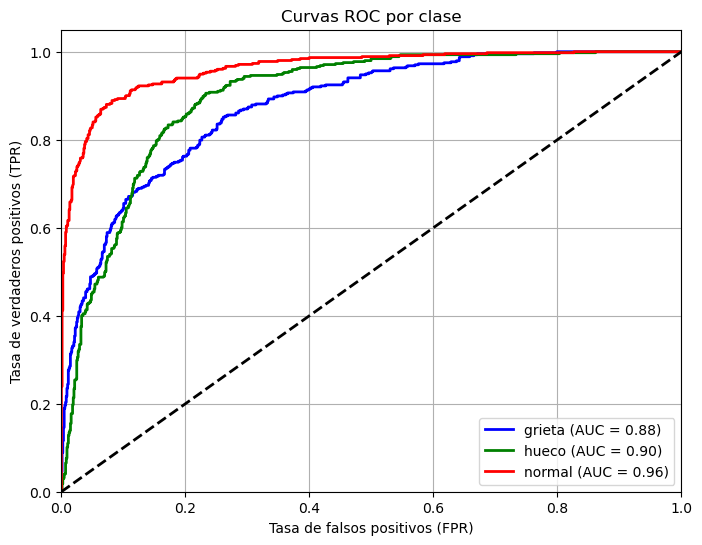

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Paso 1: Binarizamos usando los valores codificados
y_test_bin = label_binarize(y_test, classes=le.transform(le.classes_))
n_classes = y_test_bin.shape[1]

# Paso 2: Obtenemos probabilidades
y_score = grid.best_estimator_.predict_proba(X_test)

# Paso 3: Curvas ROC como antes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Paso 4: Graficar con los nombres originales de las clases
# target_names contiene los nombres originales de las clases
target_names = le.classes_

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{target_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

